# Fight-Online-Abuse

### Setup

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import AdamW, DistilBertModel, DistilBertTokenizerFast

from datasets import TextDataset
from models import DistilBertClassifier


In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


### Load the dataset


In [3]:
DATASET_DIR = Path('./datasets')
RESULT_DIR = Path('./results')
CHECKPOINT_DIR = Path('./checkpoints')
RESULT_DIR.mkdir(exist_ok=True)
CHECKPOINT_DIR.mkdir(exist_ok=True)

TRAIN_SPLIT = 0.8
MAX_LEN = 128
BATCH_SIZE = 32
LEARNING_RATE = 1e-05
EPOCHS = 10


In [4]:
df = pd.read_csv(DATASET_DIR / 'train.csv', index_col=0)
categories = df.columns[1:].values
print(f"Categories: {categories}")

df.head()


Categories: ['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate']


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


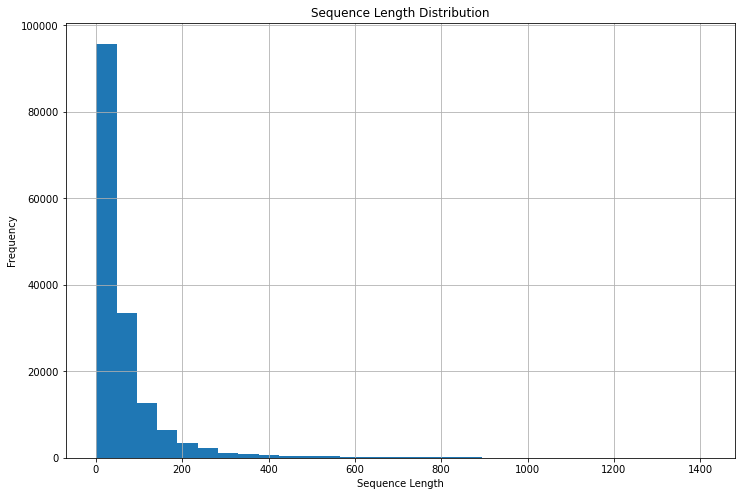

In [5]:
seq_len = [len(x.split()) for x in df["comment_text"].values]
plt.figure(figsize=(12, 8))
plt.hist(seq_len, bins=30)
plt.grid(True)
plt.title("Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.savefig(RESULT_DIR / "sequence_length_distribution.png", facecolor='w')


### Split into training and validation

In [6]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
dataset = TextDataset(df['comment_text'], df[categories].values, tokenizer, MAX_LEN)

train_size = int(TRAIN_SPLIT * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train size: {len(train_dataset)}, Valid size: {len(valid_dataset)}")


Train size: 127656, Valid size: 31915


### Load the model

In [ ]:
def generate_class_weights(y):
    class_count = y.sum(axis=0)
    class_weights = [len(y) / (len(y[0]) * freq) if freq > 0 else 1 for freq in class_count]

    return class_weights

class_weights = generate_class_weights(y_train)


In [7]:
distilBert = DistilBertModel.from_pretrained("distilbert-base-uncased")

# ? Freeze all the parameters
for param in distilBert.parameters():
    param.requires_grad = False

model = DistilBertClassifier(distilBert, len(categories)).to(device)
print(model)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()
# criterion = nn.BCEWithLogitsLoss()


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

C:\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [58]:
# # ? tokenize and encode sequences
# tokens_train = tokenizer(X_train.tolist(), max_length=256, padding='max_length', truncation=True)
# tokens_valid = tokenizer(X_valid.tolist(), max_length=256, padding='max_length', truncation=True)

# train_seq = torch.tensor(tokens_train['input_ids'])
# train_mask = torch.tensor(tokens_train['attention_mask'])
# train_y = torch.tensor(y_train.tolist())

# valid_seq = torch.tensor(tokens_valid['input_ids'])
# valid_mask = torch.tensor(tokens_valid['attention_mask'])
# valid_y = torch.tensor(y_valid.tolist())

# # ? tokenize and encode sequences
# tokens_train = tokenizer(X_train.tolist(), max_length=256, padding='max_length', truncation=True)
# tokens_valid = tokenizer(X_valid.tolist(), max_length=256, padding='max_length', truncation=True)

# train_seq = torch.tensor(tokens_train['input_ids'])
# train_mask = torch.tensor(tokens_train['attention_mask'])
# train_y = torch.tensor(y_train.tolist())

# valid_seq = torch.tensor(tokens_valid['input_ids'])
# valid_mask = torch.tensor(tokens_valid['attention_mask'])
# valid_y = torch.tensor(y_valid.tolist())


# train_dataset = TensorDataset(train_seq, train_mask, train_y)
# train_sampler = RandomSampler(train_dataset)
# train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

# valid_dataset = TensorDataset(valid_seq, valid_mask, valid_y)
# valid_sampler = SequentialSampler(valid_dataset)
# valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)


In [58]:
def train(model, dataloader, criterion, optimizer, device='cpu'):
    print("Training...")
    model.train()
    total_loss, total_accuracy = 0, 0

    # ? empty list to save model predictions
    total_preds = []

    # ? iterate over batches
    for idx, batch in enumerate(dataloader):
        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        preds = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        print(preds)

        # ? compute the loss between actual and predicted values
    #     loss = criterion(preds, labels)

    #     # add on to the total loss
    #     total_loss = total_loss + loss.item()

    #     # backward pass to calculate the gradients
    #     loss.backward()

        # ? clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # # model predictions are stored on GPU. So, push it to CPU
        # preds = preds.detach().cpu().numpy()

        # # append the model predictions
        # total_preds.append(preds)

        # ? progress update after every 50 batches.
        if (idx + 1) % 50 == 0:
            # print(f"  [Batch {idx+1}\t/{len(dataloader)}] Loss: {loss.item():.4f}")
            print(f"  [Batch {idx+1}\t/{len(dataloader)}]")

    # ? compute the training loss of the epoch
    avg_loss = total_loss / len(dataloader)

    # # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # # reshape the predictions in form of (number of samples, no. of classes)
    # total_preds = np.concatenate(total_preds, axis=0)

    # # returns the loss and predictions
    return avg_loss, total_preds

train_loss, train_preds = train(model, train_dataloader, criterion, optimizer, device)


Training...


TypeError: forward() got an unexpected keyword argument 'token_type_ids'

In [ ]:
# function for evaluating the model
def evaluate(dataloader, criterion, device):
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    for step, batch in enumerate(dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print("  Batch {:>5,}  of  {:>5,}.".format(step, len(dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = criterion(preds, labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds
